# Task time predictions from RoboMission

Data source and explanation:
- https://github.com/adaptive-learning/adaptive-learning-research/tree/master/data/robomission-2019-02-09
- check out https://colab.research.google.com/drive/1LJIbWajN9eHxn1lCJ1Jq0EZsb60YSHH-#scrollTo=3ubmmMfdEdtl

## Basic info
- Users solve tasks, predict the time to solve: Log of `time_spent` in `task_sessions.csv`.
- metric: RMSE

## Approach

### Phase 1: Baselines
1. Baseline 1: global mean
2. Baseline 2: Mean per task
3. Baseline 3: Mean per user

### Phase 2: Using time series information
4. Time series prediction
    - first task solved after a long break?
    - school situation: just before the bell rings? morning/afternoon?
5. Prediction based on user types clustering - school kid / late (maybe teacher / self-study) / outliers

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1182]:
from robomission import *
from helpers import *
pd.options.mode.chained_assignment = None 

## 1. Data loading, initial checks

In [3]:
DATA = load_attempts()
df_train = DATA['attempts'].copy()
df_test = DATA['attempts_reporting'].copy()

In [4]:
train = df_preprocess(DATA['attempts'])
test = df_preprocess(DATA['attempts_reporting'])

In [5]:
# collecting results here
all_evals = {}

## Phase 1: Baselines

### Baseline 1: Global mean
2. Calculate the mean on the train and test dataset
3. Evaluate with RMSE

In [6]:
models = [GlobalAvgModel()]
scenarios = [
    'as-observed'
]
%time all_evals["global"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating GlobalAvgModel().
Scenario: 'as-observed'.
Experiments: . . . . . Done!
Results: RMSE 1.142 (std 0.005)

Wall time: 1min 30s


### Baseline 2: Mean per task
2. Calculate the mean per item on the train dataset
3. Evaluate with RMSE on the testing one

In [150]:
models = [ItemAvgModel()]
scenarios = [
    'as-observed'
]
%time all_evals["item"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating ItemAvgModel().
Scenario: 'as-observed'.
Experiments: . . . . . Done!
Results: RMSE 0.860 (std 0.012)

Wall time: 1min 22s


### Baseline 3: Mean per user
2. Calculate the mean per user on the train dataset
3. Evaluate with RMSE on the testing one

In [151]:
models = [UserAvgModel()]
scenarios = [
    'as-observed'
]
%time all_evals["user"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating UserAvgModel().
Scenario: 'as-observed'.
Experiments: . . . . . Done!
Results: RMSE 1.146 (std 0.014)

Wall time: 1min 10s


## Evaluation for Baseline 1, 2, 3

In [356]:
models = [
    GlobalAvgModel(),
    ItemAvgModel(),
    UserAvgModel(),
]
%time eval_results_baseline = eval_models_for_seminar_report(models, train, test)

Evaluating GlobalAvgModel().
Scenario: 'as-observed'.
Results: RMSE 1.128

Evaluating ItemAvgModel().
Scenario: 'as-observed'.
Results: RMSE 0.849

Evaluating UserAvgModel().
Scenario: 'as-observed'.
Results: RMSE 1.128

Wall time: 1min 2s


In [357]:
eval_results = eval_results_baseline
eval_results_baseline

{'global-avg-as-observed': {'mean': 1.128413055553632},
 'item-avg-as-observed': {'mean': 0.8492482811413823},
 'user-avg-as-observed': {'mean': 1.1275144165706916}}

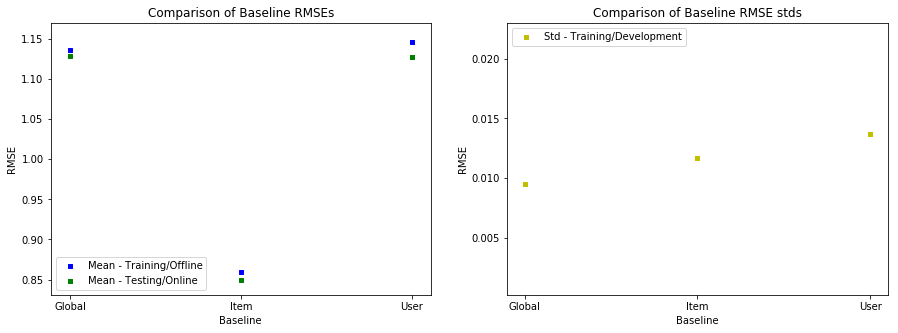

In [358]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title("Comparison of Baseline RMSEs")
ax[0].scatter(["Global", "Item", "User"], [all_evals["global"]["global-avg-as-observed"]["mean"],all_evals["item"]["item-avg-as-observed"]["mean"],all_evals["user"]["user-avg-as-observed"]["mean"]], s=20, c='b', marker="s", label='Mean - Training/Offline')
ax[0].scatter(["Global", "Item", "User"], [eval_results["global-avg-as-observed"]["mean"],eval_results["item-avg-as-observed"]["mean"],eval_results["user-avg-as-observed"]["mean"]], s=20, c='g', marker="s", label='Mean - Testing/Online')
ax[0].set_xlabel("Baseline"); ax[0].set_ylabel("RMSE")
ax[0].legend(loc='lower left');

ax[1].set_title("Comparison of Baseline RMSE stds")
ax[1].scatter(["Global", "Item", "User"], [all_evals["global"]["global-avg-as-observed"]["std"],all_evals["item"]["item-avg-as-observed"]["std"],all_evals["user"]["user-avg-as-observed"]["std"]], s=20, c='y', marker="s", label='Std - Training/Development')
ax[1].set_xlabel("Baseline"); ax[1].set_ylabel("RMSE")

ax[1].legend(loc='upper left');
plt.show()

### Baseline Random Forest

In [636]:
train_rf = train.drop(["start"], axis=1)
train_rf = train_rf.dropna()

In [637]:
rf_model = RandomForestModel()
models = [rf_model]
scenarios = [
    'as-observed'
]
%time all_evals["rf_baseline"] = eval_models(models, train_rf, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating RandomForestModel().
Scenario: 'as-observed'.
Experiments: 

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\schoolspace\adaptive\robomission.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  print(item_diffs)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


. 

C:\schoolspace\adaptive\robomission.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  print(item_diffs)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


. 

C:\schoolspace\adaptive\robomission.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  print(item_diffs)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


. 

C:\schoolspace\adaptive\robomission.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  print(item_diffs)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


. 

C:\schoolspace\adaptive\robomission.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  print(item_diffs)
C:\Users\terez\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


. Done!
Results: RMSE 0.902 (std 0.012)

Wall time: 2h 38min 31s


In [642]:
cols = train_rf.columns

In [645]:
importances = rf_model.rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(indices)):
    print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

1. feature item_order (0.341889)
2. feature startIs_quarter_end (0.094758)
3. feature startIs_month_start (0.090325)
4. feature student (0.083688)
5. feature event_order (0.064787)
6. feature item_solution (0.059913)
7. feature startIs_quarter_start (0.042667)
8. feature executions (0.041996)
9. feature startIs_month_end (0.038961)
10. feature item_setting (0.033854)
11. feature program (0.025298)
12. feature edits (0.024870)
13. feature item (0.014628)
14. feature response_time_sec (0.009291)
15. feature startHour (0.005693)
16. feature startMinute (0.005078)
17. feature startElapsed (0.004619)
18. feature time (0.004146)
19. feature isStateHolidays (0.002958)
20. feature isSummerHolidays (0.002330)
21. feature startSecond (0.001863)
22. feature startIs_year_start (0.001154)
23. feature startIs_year_end (0.001135)
24. feature startYear (0.001018)
25. feature isSchoolWorkingHours (0.000969)
26. feature startMonth (0.000792)
27. feature solved (0.000526)
28. feature startDay (0.000371)


## Phase 2: Basic ML with time series data

#### Quick exploration
- mean time for phases of the day (morning, afternoon, evening)
- make use of logistic regression for estimating time-timeOfTheDay relationship?

In [168]:
print(train[train["isMorning"]]["time"].mean())
print(train[train["isAfternoon"]]["time"].mean())
print(train[train["isEvening"]]["time"].mean())
print(train[train["isNight"]]["time"].mean())

4.068670219012556
4.171435508651109
4.213013562334699
4.279835964595468


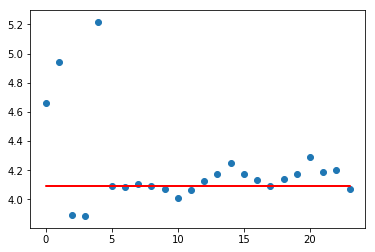

In [169]:
means = [train[train["startHour"] == x]["time"].mean() for x in train["startHour"].unique()]
plt.scatter(train["startHour"].unique(), means)
plt.plot(train["startHour"].unique(), [train["time"].mean() for i in range(24)], c='r')

Task 2, mean: 3.478766631284429


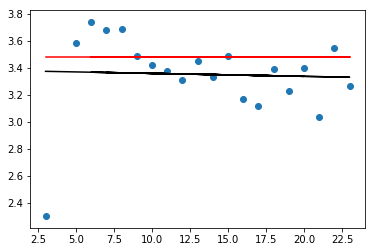

In [199]:
train_solved = train[train["solved"] == True]
for task in [2]:
    train_per_task = train_solved[train_solved["item"] == task]
    print(f"Task {task}, mean: {train_per_task['time'].mean()}")
    means = [train_per_task[train_per_task["startHour"] == x]["time"].mean() for x in train_per_task["startHour"].unique()]
    plt.scatter(train_per_task["startHour"].unique(), means)
    #print([train_per_task["startHour"].unique()])
    #print(means)
    reg = LinearRegression().fit(np.array([train_per_task["startHour"].unique()]).T, means)
    #print('Coefficients:', reg.coef_)
    #print('Intercept:', reg.intercept_ )
    y_pred = reg.predict(np.array([train_per_task["startHour"].unique()]).T)
    #print(y_pred)
    plt.plot(train_per_task["startHour"].unique(), [train_per_task["time"].mean() for i in range(len(train_per_task["startHour"].unique()))], c='r')
    plt.plot(train_per_task["startHour"].unique(), y_pred, c='k')
    plt.show()

## Time-series models:
- making use of what hour it is and what time of the day it is

### 1. GlobalAvgModelHour
Groups by starting hour, returns global average per hour

### 2. ItemAvgModelHour
Groups by starting hour, returns item average + (or -) weighted (abs) difference of item average and item average per hour

### 3. ItemAvgModelTimeOfTheDay
Groups by time of the day (isMorning, etc.), returns item average + (or -) weighted (abs) difference of item average and item average per time of the day

### 4. ItemAvgModelHourLinearRegression
Groups by time of the day (isMorning, etc.), using Linear Regression to predict item's time based on mean of times x hours

### 5. ItemAvgModelOutliersRemoval
Using z-score to calculate top 2.5\% and bottom 2.5\% outliers per task

In [181]:
models = [GlobalAvgModelHour()]
scenarios = [
    'as-observed'
]
%time all_evals["global-hour"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating GlobalAvgModelHour().
Scenario: 'as-observed'.
Experiments: . . . . . Done!
Results: RMSE 1.138 (std 0.003)

Wall time: 1min 16s


In [283]:
models = [ItemAvgModelHour()]
scenarios = [
    'as-observed'
]
%time all_evals["item-hour"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating ItemAvgModelHour().
Scenario: 'as-observed'.
Experiments: . . . . . Done!
Results: RMSE 0.880 (std 0.008)

Wall time: 3min 8s


In [302]:
models = [ItemAvgModelTimeOfTheDay()]
scenarios = [
    'as-observed'
]
%time all_evals["item-time-of-the-day"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating ItemAvgModelTimeOfTheDay().
Scenario: 'as-observed'.
Experiments: . . . . . Done!
Results: RMSE 0.881 (std 0.008)

Wall time: 2min 2s


In [346]:
models = [ItemAvgModelHourLinearRegression()]
scenarios = [
    'as-observed'
]
%time all_evals["item-time-of-the-day-linreg"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating ItemAvgModelHourLinearRegression().
Scenario: 'as-observed'.
Experiments: . . . . . Done!
Results: RMSE 0.880 (std 0.012)

Wall time: 4min 19s


In [551]:
models = [ItemAvgModelOutliersRemoval()]
scenarios = [
    'as-observed'
]
%time all_evals["item-time-od-removal"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating ItemAvgModelOutliersRemoval().
Scenario: 'as-observed'.
Experiments: . . . . . Done!
Results: RMSE 0.876 (std 0.010)

Wall time: 1min 3s


In [7]:
models = [ItemAvgModelOutliersRemoval()]
scenarios = [
    'as-observed'
]
%time all_evals["item-time-od-removal"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=5)

Evaluating ItemAvgModelOutliersRemoval().
Scenario: 'as-observed'.
Experiments: . . . . 

KeyboardInterrupt: 

In [572]:
models = [
    GlobalAvgModelHour(),
    ItemAvgModel(),
    ItemAvgModelHour(),
    ItemAvgModelTimeOfTheDay(),
    ItemAvgModelHourLinearRegression(),
    ItemAvgModelOutliersRemoval(),
    UserAvgModelHistory(),
    UserAvgModelHistoryRelative(),
]
%time eval_results_simple_timeseries = eval_models_for_seminar_report(models, train, test)

Evaluating GlobalAvgModelHour().
Scenario: 'as-observed'.
Results: RMSE 1.128

Evaluating ItemAvgModel().
Scenario: 'as-observed'.
Results: RMSE 0.849

Evaluating ItemAvgModelHour().
Scenario: 'as-observed'.
Results: RMSE 0.849

Evaluating ItemAvgModelTimeOfTheDay().
Scenario: 'as-observed'.
Results: RMSE 0.849

Evaluating ItemAvgModelHourLinearRegression().
Scenario: 'as-observed'.
Results: RMSE 0.850

Evaluating ItemAvgModelOutliersRemoval().
Scenario: 'as-observed'.
Results: RMSE 0.849

Evaluating UserAvgModelHistory().
Scenario: 'as-observed'.
Results: RMSE 0.852

Evaluating UserAvgModelHistoryRelative().
Scenario: 'as-observed'.
Results: RMSE 0.849

Evaluating UserAvgModelHistory().
Scenario: 'as-observed'.
Results: RMSE 0.852

Evaluating UserAvgModelHistoryHandicapOnFirstTaskEver().
Scenario: 'as-observed'.
-1.1815847459563704 instd. of -1.050297551961218
0.3350238545777583 instd. of 0.5741139016709
0.9808664942675174 instd. of 1.5693863908280279
Results: RMSE 0.852

Wall time: 4

In [1185]:
eval_results_simple_timeseries

({'global-avg-hour-as-observed': {'mean': 1.1280691050526173},
  'item-avg-as-observed': {'mean': 0.8492482811413823},
  'item-avg-hour-as-observed': {'mean': 0.8494184098216281},
  'item-avg-time-of-the-day-as-observed': {'mean': 0.8492952171289008},
  'item-avg-hour-linear-regression-as-observed': {'mean': 0.8495133696798771},
  'item-avg-outliers-removal-as-observed': {'mean': 0.8491681406782097},
  'user-avg-history-as-observed': {'mean': 0.8518012035839339},
  'user-avg-history-relative-as-observed': {'mean': 0.8493010280560286},
  'user-avg-history-handicap-on-first-task-ever-as-observed': {'mean': 0.851585803299341}},
 [3.5098304009148498,
  3.2143528212559715,
  3.304972944836235,
  3.4610515305644065,
  3.0395753369010228,
  3.757959144357667,
  5.619444195461921,
  4.854520473286377,
  4.487012648882517,
  3.5098304009148498,
  3.5098304009148498,
  3.2143528212559715,
  3.5098304009148498,
  3.5098304009148498,
  3.4610515305644065,
  3.5098304009148498,
  3.478766631284429,

In [1243]:
models_ = [
    ItemAvgModelOutliersRemovalCombination()
]

%time eval_results_simple_timeseries_exp = eval_models_for_seminar_report(models, train, test)

Evaluating ItemAvgModelOutliersRemovalCombination().
Scenario: 'as-observed'.
Results: RMSE 0.848

Wall time: 38.3 s


### Stage 4: Exploration of the data in test and their predictions 

In [890]:
def test_with_predictions(preds):
    test_solved = test[test["solved"] == True]
    #test_solved = test_solved[["student", "item", "time"]]
    test_solved["time_pred"] = preds
    test_solved["diff"] = abs(test_solved["time_pred"] -  test_solved["time"])
    return test_solved
test_solved = test_with_predictions(eval_results_simple_timeseries[1])

In [891]:
biggest_errors = test_solved.sort_values("diff", ascending=False)
students_in_train = []; students_not_in_train=[]
s = biggest_errors["student"].unique()
for s_ in s:
    if train[train["student"] == s_]["student"].count() > 0:
        students_in_train.append(s_)
        #display(train[train["student"] == s_])
    else:
        students_not_in_train.append(s_)

In [914]:
biggest_errors.head()

event_order  student  item                            start  \
id                                                                    
115738       105828    16879    10 2019-04-17 07:06:56.493139+00:00   
126414       115751    17622    10 2019-05-17 08:22:23.893838+00:00   
126727       116015    17651    44 2019-05-20 07:53:43.241974+00:00   
126411       115748    17623    44 2019-05-17 08:21:13.885668+00:00   
117015       107007    16923    44 2019-04-29 08:04:50.480080+00:00   

        item_setting  item_solution  item_order  solved      time  \
id                                                                  
115738            70             69          11    True  8.188689   
126414            70             69          11    True  8.188689   
126727            77             70           3    True  8.188689   
126411            77             70           3    True  8.188689   
117015            77             70           3    True  8.188689   

        response_time_sec  ...  isSchoolWorkingHours  isSchoolBreak  \
id                         ...                                        
115738               5509  ...                 False          False   
126414              10708  ...                  True          False   
126727               6711  ...                 False          False   
126411              10647  ...                  True          False   
117015               3667  ...                  True          False   

        isWeekend  isShortlyBeforeBreak  isMorning  isAfternoon  isEvening  \
id                                                                           
115738      False                 False       True        False      False   
126414      False                 False       True        False      False   
126727      False                 False       True        False      False   
126411      False                 False       True        False      False   
117015      False                 False       True        False      False   

        isNight  time_pred      diff  
id                                    
115738    False   3.039575  5.149114  
126414    False   3.039575  5.149114  
126727    False   3.214353  4.974336  
126411    False   3.214353  4.974336  
117015    False   3.214353  4.974336  

[5 rows x 41 columns]

In [594]:
biggest_errors = test_solved.sort_values("diff", ascending=False)[:1000]
students_in_train = []; students_not_in_train=[]
s = biggest_errors["student"].unique()
for s_ in s:
    if train[train["student"] == s_]["student"].count() > 0:
        students_in_train.append(s_)
        #display(train[train["student"] == s_])
    else:
        students_not_in_train.append(s_)
len(students_in_train)/len(students_not_in_train)

0.05311355311355311

In [554]:
eval_results_simple_timeseries

{'global-avg-hour-as-observed': {'mean': 1.1280691050526173},
 'item-avg-hour-as-observed': {'mean': 0.8494184098216281},
 'item-avg-time-of-the-day-as-observed': {'mean': 0.8492952171289008},
 'item-avg-hour-linear-regression-as-observed': {'mean': 0.8495133696798771},
 'item-avg-outliers-removal-as-observed': {'mean': 0.8491681406782097}}

In [555]:
all_evals

{'global': {'global-avg-as-observed': {'mean': 1.1357406183617806,
   'std': 0.00947856266511001}},
 'item': {'item-avg-as-observed': {'mean': 0.8596727691971923,
   'std': 0.01169962407889209}},
 'user': {'user-avg-as-observed': {'mean': 1.1458549180018358,
   'std': 0.013723071017015018}},
 'item-hour': {'item-avg-hour-as-observed': {'mean': 0.8799190224389619,
   'std': 0.008299710937937368}},
 'item-time-of-the-day': {'item-avg-time-of-the-day-as-observed': {'mean': 0.8807549844255187,
   'std': 0.008301393396732379}},
 'global-hour': {'global-avg-hour-as-observed': {'mean': 1.079652758794868,
   'std': 0.007883222519223538}},
 'item-time-of-the-day-linreg': {'item-avg-hour-linear-regression-as-observed': {'mean': 0.8797398683608192,
   'std': 0.012357550555548717}},
 'item-time-od-removal': {'item-avg-outliers-removal-as-observed': {'mean': 0.8764525138840961,
   'std': 0.010421982977873777}}}

In [559]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.set_title("Comparison of RMSEs")
ax.scatter(["Global", "Item", "User"], [eval_results["global-avg-as-observed"]["mean"],eval_results["item-avg-as-observed"]["mean"],eval_results["user-avg-as-observed"]["mean"]], s=20, c='g', marker="s", label='Mean - Testing/Online')
ax.scatter(["Global", "Item", "User"], [all_evals["global"]["global-avg-as-observed"]["mean"],all_evals["item"]["item-avg-as-observed"]["mean"],all_evals["user"]["user-avg-as-observed"]["mean"]], s=20, c='b', marker="s", label='Mean - Training/Offline')
ax.scatter(["Global-Hour Avg", "Item-Hour Avg", "Item-ToD Avg", "Item-ToD LinReg", "Item-Avg OD"], 
           [eval_results_simple_timeseries["global-avg-hour-as-observed"]["mean"],
            eval_results_simple_timeseries["item-avg-hour-as-observed"]["mean"],
            eval_results_simple_timeseries["item-avg-time-of-the-day-as-observed"]["mean"],
            eval_results_simple_timeseries["item-avg-hour-linear-regression-as-observed"]["mean"],
            eval_results_simple_timeseries["item-avg-outliers-removal-as-observed"]["mean"]], s=20, c='g', marker="s")
ax.scatter(["Global-Hour Avg", "Item-Hour Avg", "Item-ToD Avg", "Item-ToD LinReg", "Item-Avg OD"], 
              [all_evals["global-hour"]["global-avg-hour-as-observed"]["mean"],
               all_evals["item-hour"]["item-avg-hour-as-observed"]["mean"],
               all_evals["item-time-of-the-day"]["item-avg-time-of-the-day-as-observed"]["mean"],
               all_evals["item-time-of-the-day-linreg"]["item-avg-hour-linear-regression-as-observed"]["mean"],
               all_evals["item-time-od-removal"]["item-avg-outliers-removal-as-observed"]["mean"]], s=20, c='b', marker="s")
ax.set_xlabel("Baseline"); ax.set_ylabel("RMSE")
ax.legend(loc='upper right');
plt.show()

In [602]:
print("FINAL RANKING:")
results = {}
for k, v in eval_results_simple_timeseries.items():
    results[k] = v["mean"]
    
for k, v in eval_results.items():
    results[k] = v["mean"]
    
sorted_x = sorted(results.items(), key=lambda kv: kv[1])
sorted_x

FINAL RANKING:


[('item-avg-outliers-removal-as-observed', 0.8491681406782097),
 ('item-avg-as-observed', 0.8492482811413823),
 ('item-avg-time-of-the-day-as-observed', 0.8492952171289008),
 ('item-avg-hour-as-observed', 0.8494184098216281),
 ('item-avg-hour-linear-regression-as-observed', 0.8495133696798771),
 ('user-avg-as-observed', 1.1275144165706916),
 ('global-avg-hour-as-observed', 1.1280691050526173),
 ('global-avg-as-observed', 1.128413055553632)]

In [747]:
#ItemAvgModelUserSolvedCount
models = [ItemAvgModelUserSolvedCount()]
scenarios = [
    'as-observed'
]
%time all_evals["item-user-count-solved"] = eval_models(models, train, scenarios=scenarios, n_experiments_per_scenario=1)

Evaluating ItemAvgModelUserSolvedCount().
Scenario: 'as-observed'.
Experiments: . Done!
Results: RMSE 0.862 (std nan)

Wall time: 13 s


In [1231]:
X = solved_attempts.drop(get_performance_columns(), axis=1)
y = solved_attempts[["time"]]

X_test = test[test["solved"] == True].drop(get_performance_columns(), axis=1)
y_test = test[test["solved"] == True][["time"]]

reg = BayesianRidge().fit(X, y)
y_pred = reg.predict(X_test)
compute_RMSE(y_test, y_pred)

C:\Users\terez\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9832636542314137